In [1]:
import glob
import sys
import json
import pandas as pd

## List chains

In [4]:

chains = pd.read_json('/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_chains.json')
print(len(chains))
print(chains.pdb_code.nunique())
chains

595878
170634


,uniprotkb_id,pdb_code,chain_id,uniprot_group_size
0,P00720,161l,A,886
1,P00720,152l,A,886
2,P00720,166l,A,886
3,P00720,159l,A,886
4,P00720,113l,A,886
...,...,...,...,...
595873,O67035,7f3e,H,12
595874,O67035,7f3e,I,12
595875,O67035,7f3e,J,12
595876,O67035,7f3e,K,12


## Filter structures

In [2]:
import sys

from apo_holo_structure_stats.pipeline.utils.json import read_jsons_with_seqs

filtered__json_folder = '/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/meta_output/2022-04-29/filter/filter_output.json.d/*'

df = read_jsons_with_seqs(glob.glob(filtered__json_folder))
df = df.drop(columns='sequence')


loading filter_output.json559: 700/700
concatenating...
done.


In [3]:
df.describe(include='all')


,uniprotkb_id,pdb_code,uniprot_group_size,path,chain_id,is_holo,resolution,_exptl.method
count,249697,249697,249697.000000,249697,249697,249697,249697.000000,249697
unique,29386,112635,NaN,118876,350,2,NaN,4
top,P0DTD1,7bgl,NaN,../input/pdb_structs365/7rwt.cif.gz,A,True,NaN,X-RAY DIFFRACTION
freq,1490,78,NaN,60,108692,163523,NaN,246495
mean,NaN,NaN,122.077954,NaN,NaN,NaN,1.970795,NaN
std,NaN,NaN,260.245707,NaN,NaN,NaN,0.338090,NaN
min,NaN,NaN,2.000000,NaN,NaN,NaN,0.480000,NaN
25%,NaN,NaN,8.000000,NaN,NaN,NaN,1.750000,NaN
50%,NaN,NaN,25.000000,NaN,NaN,NaN,2.000000,NaN
75%,NaN,NaN,101.000000,NaN,NaN,NaN,2.240000,NaN


Compute upper bound of count of a-h pairs (for each uniprot group)

In [4]:
by_unp = df.groupby('uniprotkb_id')
holos_by_group = by_unp['is_holo'].sum()
apos_by_group = by_unp['is_holo'].count() - holos_by_group

ub_pairs_by_group = (apos_by_group * holos_by_group).rename('upper_bound_on_pairs')
print('ub on all pairs:', ub_pairs_by_group.sum())
ub_pairs_by_group.describe()


ub on all pairs: 2690740


count     29386.000000
mean         91.565371
std        3637.177809
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      510925.000000
Name: upper_bound_on_pairs, dtype: float64

clip: 10 ub_pairs: 56317 ecdf:  0.8668
clip: 100 ub_pairs: 210113 ecdf:  0.9656
clip: 1000 ub_pairs: 557263 ecdf:  0.9932
clip: inf ub_pairs: 2690740 ecdf:  0.0000


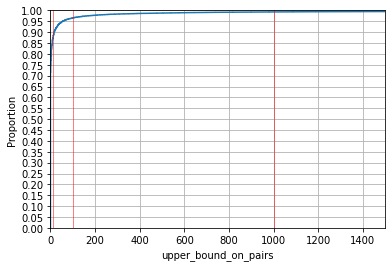

In [5]:
from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(ub_pairs_by_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 1000, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(ub_pairs_by_group.to_numpy()), np.linspace(0, 1, len(ub_pairs_by_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'ub_pairs:', ub_pairs_by_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')

plt.show()


## Make Pairs LCS

In [6]:
import pandas as pd
import json
#
# potential_pairs = pd.read_json('/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs', )
# print(len(potential_pairs))
#


In [7]:
json_filename = '/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/meta_output/2022-04-29/make_pairs/pairs.json'
with open(json_filename) as f:
    potential_pairs = pd.json_normalize(json.load(f))


In [8]:
potential_pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,2.690740e+06,2.690740e+06,2.690740e+06,2.690740e+06,2.690740e+06,2.690740e+06
mean,1.377614e+02,3.634823e+01,4.901014e+01,6.345996e+01,2.641469e+01,3.704527e+01
std,1.182538e+02,7.351079e+01,8.688338e+01,7.829397e+01,5.007045e+01,6.274535e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.160000e+02,2.000000e+00,4.000000e+00,4.100000e+01,0.000000e+00,0.000000e+00
75%,1.960000e+02,4.600000e+01,7.800000e+01,1.030000e+02,3.400000e+01,5.800000e+01
max,1.524000e+03,2.115000e+03,1.342000e+03,1.096000e+03,1.068000e+03,8.950000e+02


In [9]:
print(len(potential_pairs))
pairs = potential_pairs[potential_pairs['lcs_result.mismatches'] == 0]
print(len(pairs))

2690740
1016458


In [10]:
len(pairs[pairs['lcs_result.length'] < 50])
# todo I can remove those from results
# and the shortest give errors in run_analyses (if all are unobserved - 0 residues), but that's ok..

791

In [11]:
pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,1.016458e+06,1.016458e+06,1.016458e+06,1016458.0,1016458.0,1016458.0
mean,2.116836e+02,3.174208e+00,4.544811e+00,0.0,0.0,0.0
std,1.086958e+02,1.582565e+01,2.107452e+01,0.0,0.0,0.0
min,3.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
25%,1.290000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
50%,1.690000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
75%,3.050000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
max,1.524000e+03,5.720000e+02,9.050000e+02,0.0,0.0,0.0


In [12]:
# todo join with unp ids and find out the distribution in groups.
# if same as potential pairs or not.
chains = pd.read_json('/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_chains.json')
pairs = pairs.merge(chains.set_index(['pdb_code', 'chain_id']), left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)

In [13]:
pairs.columns

Index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo',
       'lcs_result.length', 'lcs_result.i1', 'lcs_result.i2',
       'lcs_result.mismatches', 'lcs_result.leading_mismatches',
       'lcs_result.trailing_mismatches', 'uniprotkb_id', 'uniprot_group_size'],
      dtype='object')

In [14]:
pairs_per_group = pairs.groupby('uniprotkb_id').size()
pairs_per_group.describe()

count      6408.000000
mean        158.843477
std        3077.140315
min           1.000000
25%           2.000000
50%           6.000000
75%          18.000000
max      134404.000000
dtype: float64

Z hlediska cachování modelů by mě zajímalo, kolikrát maximálně (a průměrně) v párech figuruje jedna struktura. (A všechno jsou ekvivalence/je to tranzitivní? Nutně nemusí, jde-li o jiné úseky třeba, ale většinou jo, je-li tam nějaký překryv, je to implikováno, ale? - počítám a1, a2 k h1 a pak vezmeš h2, která je na a1, je taky k a2? Za předpokladu, že mají LCS(a1, h1) a LCS(a1, h2) nějaký překryv.

No každopádně -- udělej groupby struktura sizes... (ani nemusíš myslim podle uniprotu)

Dalo by se to dělat takto
- načíst vždy 5 apo a k nim vystridat 5 holo, dalsich 5 holo,...
    - 25 párů a pouze 5 načítání -> 5x reduction in parsing structures time

A když jsme u zrychlování - nemusím načítat nebo aspoň držet v paměti celou strukturu, když mi stačí chain (nebo ty set_of_residues)
- samozřejmě biopython má reference i nahoru, takže bych ten chain musel disconnectnout, pokud chci pracovat s residues objekty (a ne treba jenom c alpha coords)
    - na to c alpha coords bych si mohl koneckonců napsat parser sám,... ale to už ne (potřebuju všechny atomy, pro interface, ne jen calpha..)
    - no ale dalo by se to udelat megaefektivne - jenom coords v numpy a treba indices AAs/ atom typy
    - asi musim prijmout, ze to neni efektivni a pouzivam to...
    - kazdopadne, chain bych disconnectnout mohl?

In [15]:
from typing import List


def total_when_clipped(upper_clips: List[float], group_counts, ax=None, color='r', label='counts'):

    def find_nearest_idx(array, value):
        return (np.abs(array - value)).argmin()

    ecdf_y, ecdf_x = np.sort(group_counts.to_numpy()), np.linspace(0, 1, len(group_counts), endpoint=False)

    for clip in upper_clips:
        if ax:
            ax.axvline(clip, c=color, lw=0.5)
        ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
        print('clip:', clip, f'{label}:', group_counts.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')



# apo
count    32772.000000
mean        31.059105
std         66.153540
min          1.000000
25%          2.000000
50%          6.000000
75%         22.000000
max        621.000000
dtype: float64
clip: 5 total pairs cached: 120173 ecdf:  0.4599
clip: 10 total pairs cached: 191186 ecdf:  0.6154
clip: 50 total pairs cached: 487088 ecdf:  0.8407
clip: inf total pairs cached: 1017869 ecdf:  0.0000
# holo
count    54531.000000
mean        18.665878
std         73.527340
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        819.000000
dtype: float64
clip: 5 total pairs cached: 179592 ecdf:  0.5844
clip: 10 total pairs cached: 261862 ecdf:  0.7578
clip: 50 total pairs cached: 496407 ecdf:  0.9320
clip: inf total pairs cached: 1017869 ecdf:  0.0000


Text(0.5, 1.0, '# pairs per structure')

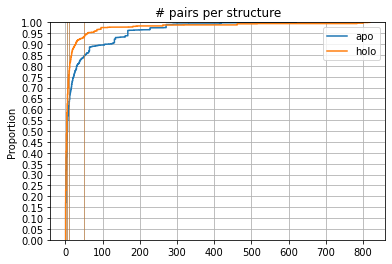

In [16]:
colors = iter(sns.color_palette())
for a_or_h in ('apo', 'holo'):
    print('#', a_or_h)
    pairs_per_apo = pairs.groupby([f'pdb_code_{a_or_h}', f'chain_id_{a_or_h}']).size()
    print(pairs_per_apo.describe())
    ax = sns.ecdfplot(pairs_per_apo, label=a_or_h)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    total_when_clipped([5, 10, 50, np.inf], pairs_per_apo, ax=ax, color=next(colors), label='total pairs cached')
plt.grid()
ax.legend()
plt.title('# pairs per structure')



count    32772.000000
mean        31.059105
std         66.153540
min          1.000000
25%          2.000000
50%          6.000000
75%         22.000000
max        621.000000
dtype: float64


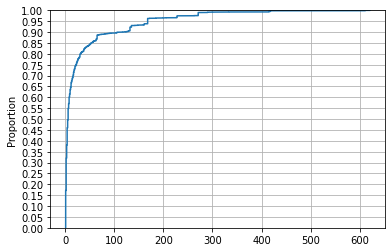

In [17]:
pairs_per_apo = pairs.groupby(['pdb_code_apo', 'chain_id_apo']).size()
print(pairs_per_apo.describe())
ax = sns.ecdfplot(pairs_per_apo)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.grid()

clip: 10 pairs: 38368 ecdf:  0.6273
clip: 100 pairs: 121870 ecdf:  0.9213
clip: 200 pairs: 159623 ecdf:  0.9529
clip: 1700 pairs: 317710 ecdf:  0.9922
clip: inf pairs: 1017869 ecdf:  0.0000


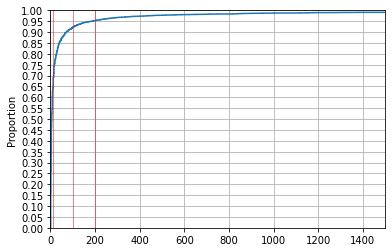

In [18]:

from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(pairs_per_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 200, 1700, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(pairs_per_group.to_numpy()), np.linspace(0, 1, len(pairs_per_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'pairs:', pairs_per_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')


[(0.0, 30.0)]

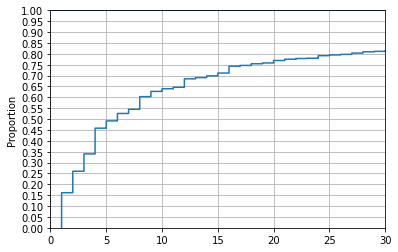

In [19]:
# musel jsem to zkopirovat, nevim, jak to zobrazit znova s jinym xlim
ax = sns.ecdfplot(pairs_per_group)
plt.axhline(np.max(ax.lines[0].get_ydata()))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set(xlim=(0, 30))

## Run analyses

In [20]:

# import matplotlib as mpl
# # do prdele, rozbiji to tohle? Proc tu nejsou grafy? Mozna nejdriv importovat seaborn? Nebo restartovat počítač?
# # mpl.rcdefaults()  # for some reason makes charts ~2x bigger (but values before and after are only by 20% larger...)
#
# mpl.rc('figure', dpi=150)

TODO
- mozna filtrovat na lcs len >= 50 (par jich je nesmyslnejch)
- zobrazit si jenom 1 zastupce z uniprot skupiny (ale to clusterovani jako oni je asi lepsi)
  - jenom join s chainy (nahore join s makepairslcs, to se ale nevejde uz do ramky, ne?, mozna ze jenom len vejde, ale musel bych ho vyzobnout v json.load
  - clusterovani
    - mozna by stacilo si stahnout to uniref nebo co, kde jsou podle thresholdu! A nemusel bych to delat
     vubec sam (i kdyz tam 1 nevyhoda tech neprekryvů ale stejny uniprot - jina cast proste, dokonce to meli i oni asi 4? takovy reprezentanty, no, z 500.. tak asi nic xtra dulezityho)
- pokud neudelam clusterovani, mozna by to chtelo neco jinyho nez tyhle tecky.. bud krizky nebo heat/hue

Proc se nektery grafy lisi of paperu/naší replikace
- raw-všechny páry nejsou clusterovaný ani vyvážený v rámci uniprot skupiny, takže ty velký převážej a ty percentage grafy pak vypadaj jinak (např ss identity má mnohem vyšší část u 0.98-1, protože se zrovna v početný unp skupině nemění moc ss (asi))
- jinak vypadaj hlavne percentage grafy


Load input files (outputs from `run_analyses`):

In [21]:
from apo_holo_structure_stats.pipeline.utils.json import read_jsons_to_df
from apo_holo_structure_stats.core.json_deserialize import tuple_it, unfold_tuple_to_columns, tuple_columns

import itertools
from pathlib import Path

import pandas as pd

# import importlib
# import apo_holo_structure_stats
# importlib.reload(apo_holo_structure_stats.pipeline.utils.json)


OUTPUT_PATH = '/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/meta_output/2022-04-29/run_analyses/output'
OUTPUT_PATH = Path(OUTPUT_PATH)

analyses_jsons = OUTPUT_PATH.rglob('output_apo_holo*')
domains_jsons = OUTPUT_PATH.rglob('output_domains*')

# for testing
# analyses_jsons = itertools.islice(analyses_jsons, 100)
# domains_jsons = itertools.islice(domains_jsons, 100)

analyses_df = read_jsons_to_df(analyses_jsons)
domain_info = read_jsons_to_df(domains_jsons)
domain_info = domain_info.applymap(tuple_it)

print(len(analyses_df))
print(len(domain_info))

loading output_apo_holo_2022-05-01T19:45:26.629409.json: 1500/1500
concatenating...
done.
loading output_domains_info_2022-05-01T19:45:26.629409.json: 1500/1500
concatenating...
done.
4981424
3878087


Proč ~je~ bylo filů jen 385?
- u 7 jobů se nenainstaloval package (pip seaborn, pandas), WTF?
- co ty zbylé? těch 8?

celkem 15 jsem nasel pomocí  `grep -e 'ERROR:[^a][^p]' run_analyses_fixed/job_script*`
takže všechny

vyřešil jsem to zatim pomocí metacentrum_scripts/submit_failed_run_analyses.py
- prostě spustím job znova..

Nevim, co to zpusobuje, mozna by to vyresil vetsi timeout v pipu?
Nektery chyby vypadaj zpusobeny 2 pipama, ale vzdy pouzivam `pip`, i u jeho upgradu, tak nevim, kde by mohl nastat rozdil
    - protoze pip se tam uspesne upgraduje, a pak to pise, ze se upgradovat výš z té původní, na tu, kde přece teďka nově je ... wtf..

Nevim, jestli je problem třeba jen na některých comp. nodech, zkusil jsem jeden (kde byla jedna z tech chyb) a normalně to fungovalo, takze ne nutně.

https://stackoverflow.com/questions/59702111/intermittent-pip-install-error-in-virtualenv
https://stackoverflow.com/questions/53661293/why-is-pip-asking-me-to-upgrade-when-its-already-up-to-date

DH:
už se mu to stalo, asi má pypi nějaký limity na IP adresu, šlo by vyřešit proxy serverem, který by si ty balíčky cachoval, aby se ty stejné (architektury) nestahovaly z pypi znovu
- myslim ale, ze to uz cachuje v home diru na metacentru (nebo aspon to tam zapisuje dle modified date). Tak mozna ne primo ty balicky, ale vsechny responses na requesty?


````
run_analyses_fixed/job_script043.sh.e9899023:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script043.sh.e9899023:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script043.sh.e9899023:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899023.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script052.sh.e9899030:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899030.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script060.sh.e9899361:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899361.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script061.sh.e9899332:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script061.sh.e9899332:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script061.sh.e9899332:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899332.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script097.sh.e9899018:  ERROR: Could not find a version that satisfies the requirement seaborn==0.11.2 (from -r requirements.txt (line 8)) (from versions: none)
run_analyses_fixed/job_script097.sh.e9899018:ERROR: No matching distribution found for seaborn==0.11.2 (from -r requirements.txt (line 8))
run_analyses_fixed/job_script097.sh.e9899018:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899018.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script146.sh.e9899358:ERROR: Could not find a version that satisfies the requirement pandas==1.3.4 (from versions: none)
run_analyses_fixed/job_script146.sh.e9899358:ERROR: No matching distribution found for pandas==1.3.4
run_analyses_fixed/job_script167.sh.e9899357:ERROR: Could not find a version that satisfies the requirement pandas==1.3.4 (from versions: none)
run_analyses_fixed/job_script167.sh.e9899357:ERROR: No matching distribution found for pandas==1.3.4
run_analyses_fixed/job_script270.sh.e9899090:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899090.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script277.sh.e9899296:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899296.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script308.sh.e9899012:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899012.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script328.sh.e9899011:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899011.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script342.sh.e9899027:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899027.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script379.sh.e9899326:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script379.sh.e9899326:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script379.sh.e9899326:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899326.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script393.sh.e9899301:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script393.sh.e9899301:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script393.sh.e9899301:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899301.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats


````

Chyba `File "setup.py" not found. Directory cannot be installed in editable` znamená, že se neaktualizoval pip

In [22]:
from collections import defaultdict

analyses_by_level = defaultdict(list)

for obj in analyses_df.itertuples():
    obj = obj._asdict()
    obj['args'] = tuple_it(obj['args'])  # json converted all my tuples to lists... won't work with hashing for joins..
    analyses_by_level[obj['level_tag']].append(obj)

# todo possibly del analyses_df

# convert analyses outputs to DataFrames
for k in analyses_by_level:
    analyses_by_level[k] = pd.DataFrame(analyses_by_level[k])


In [23]:
analyses_by_level

defaultdict(list,
            {'chain2chain':          Index              analysis_name                    args kwargs  \
             0            0                    GetRMSD  ((2oxu, A), (4h84, B))     {}   
             1            1  CompareSecondaryStructure  ((2oxu, A), (4h84, B))     {}   
             2            4                    GetRMSD  ((2oxu, A), (5d2b, A))     {}   
             3            5  CompareSecondaryStructure  ((2oxu, A), (5d2b, A))     {}   
             4            8                    GetRMSD  ((2oxu, A), (5i0l, A))     {}   
             ...        ...                        ...                     ...    ...   
             2017429   6295  CompareSecondaryStructure  ((5p0f, A), (4er2, E))     {}   
             2017430   6304                    GetRMSD  ((5p0f, A), (4er4, E))     {}   
             2017431   6305  CompareSecondaryStructure  ((5p0f, A), (4er4, E))     {}   
             2017432   6314                    GetRMSD  ((5p0f, A), (4kup, A)

In [24]:
import math
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


import importlib
import apo_holo_structure_stats
from apo_holo_structure_stats.core.json_deserialize import unfold_tuple_to_columns

In [25]:
from pathlib import Path

# sns.reset_orig()
sns.set_context('talk')
matplotlib.rcParams['figure.figsize'] = 8,6

plot_counter = 0
plot_path = Path('output_plots')
plot_path.mkdir(exist_ok=True)

def save_plot():
    global plot_counter
    plt.savefig(str(plot_path / f'paper_plot{plot_counter}.png'))
    plot_counter += 1

In [26]:
# keep False to exclude chimeric chains (that are included due to a mistake, more info at filter_structures.py:268)
a_h_pairs = analyses_by_level['chain2chain'].drop_duplicates(['analysis_name', 'args'], keep=False)['args'].drop_duplicates()
# unfold the tuple of chains into two columns
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['apo_chain','holo_chain'])
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['pdb_code_apo', 'chain_id_apo'], 'apo_chain')


In [27]:
from apo_holo_structure_stats.pipeline.make_pairs_lcs import load_pairs_json, pairs_without_mismatches

pairs_filename = '/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs'
pairs = pairs_without_mismatches(load_pairs_json(pairs_filename))
pairs_with_lengths = pairs[['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo']].assign(
    lcs_len=[lcs_result.length for lcs_result in pairs.lcs_result]
).set_index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo'])
# apparently, there are some dupes in o_make_pairs_lcs, could be because there are (are there?) dupes of chains in different uniprot groups in the segments observed file? I thought I removed them??
pairs_with_lengths = pairs_with_lengths[~pairs_with_lengths.index.duplicated()]

a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['pdb_code_holo', 'chain_id_holo'], 'holo_chain')
a_h_pairs = a_h_pairs.merge(pairs_with_lengths,
                             left_on=['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo'],
                             right_index=True)

print(len(a_h_pairs))
a_h_pairs = a_h_pairs[a_h_pairs.lcs_len >= 50]
print(len(a_h_pairs))


887052
886869


In [28]:
# domain_info = domain_info.rename(columns={'result': 'domain_count'})
# I forgot to not save duplicates in run_analyses for full domains, so remove them
# unfortunately due to analyzed_domains being in the same json, it has some NaN cols, so I need to do .drop_duplicates('full_id')
full_domains = domain_info[domain_info['type'] == 'full_domain'].drop_duplicates('full_id').set_index('full_id', verify_integrity=True)

analyzed_domains = domain_info[domain_info['type'] == 'analyzed_domain']
# because of a mistake in removing chimeric chains (>1 uniprot for the chains), there are some left, remove them (should do it for each analysis here)
# more info at filter_structures.py:268
# there are only 600 of the dupes
# todo might do keep=False, but I don't want to remove in from every analysis, too time consuming
analyzed_domains = analyzed_domains.drop_duplicates(['full_id', 'pair_id']).set_index(['full_id', 'pair_id'], verify_integrity=True)


full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
# full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
analyzed_domain_counts = analyzed_domains.groupby(by=['pdb_code', 'chain_id']).size()
print(full_domain_counts)
print('single domain proteins', full_domain_counts[full_domain_counts == 1].count())
print('multi domain proteins', full_domain_counts[full_domain_counts > 1].count())

pdb_code  chain_id
104m      A           1
105m      A           1
10gs      A           2
          B           2
11ba      A           1
                     ..
9rat      A           1
9rnt      A           1
9rsa      A           1
          B           1
9xia      A           1
Length: 69192, dtype: int64
single domain proteins 46588
multi domain proteins 22604


In [29]:
full_domains

,type,pdb_code,chain_id,domain_id,spans,pair_id,spans_auth_seq_id
full_id,,,,,,,
"(2oxu, A, 2oxuA00)",full_domain,2oxu,A,2oxuA00,"((2, 159),)",NaN,NaN
"(4h84, B, 4h84B00)",full_domain,4h84,B,4h84B00,"((1, 159),)",NaN,NaN
"(5d2b, A, 5d2bA00)",full_domain,5d2b,A,5d2bA00,"((1, 159),)",NaN,NaN
"(5i0l, A, 5i0lA00)",full_domain,5i0l,A,5i0lA00,"((2, 159),)",NaN,NaN
"(5i0l, B, 5i0lB00)",full_domain,5i0l,B,5i0lB00,"((1, 159),)",NaN,NaN
...,...,...,...,...,...,...,...
"(5pg3, A, 5pg3A00)",full_domain,5pg3,A,5pg3A00,"((22, 136),)",NaN,NaN
"(5p0d, A, 5p0dA01)",full_domain,5p0d,A,5p0dA01,"((5, 174),)",NaN,NaN
"(5p0d, A, 5p0dA02)",full_domain,5p0d,A,5p0dA02,"((175, 330),)",NaN,NaN


In [30]:
domain_info['chain'] = list(zip(domain_info.pdb_code, domain_info.chain_id))


multi_domain_chains = full_domain_counts[full_domain_counts > 1]
single_domain_chains = full_domain_counts[full_domain_counts == 1]

print(single_domain_chains.count())
print(multi_domain_chains.count())

print(len(multi_domain_chains))
# print(domain_count)
print(len(single_domain_chains))

# label single, multi domain pairs
a_h_pairs = a_h_pairs.merge(full_domain_counts.rename('domain_count'), left_on=['pdb_code_apo', 'chain_id_apo'],                                                                                            right_index=True)
#
# multi_domain_pairs = a_h_pairs.merge(multi_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                   'holo_chain']]
# single_domain_pairs = a_h_pairs.merge(single_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                                                                                                                    'holo_chain']]
# chci col a-h tuplů, a col single/multi

# todo
# describe pairs - count, min, max length (don't have that in saved metadata)
# filter two-domain arrangements (if of both apo and holo > 200 A^2)

46588
22604
22604
46588


Here optionally choose one pair for each uniprot group

In [31]:
print(len(a_h_pairs))

743182


In [32]:
def one_pair_per_uniprot(a_h_pairs):
    chains_with_uniprots = pd.read_json('/Users/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_chains.json')
    chains_with_uniprots = chains_with_uniprots.set_index(['pdb_code', 'chain_id'])
    a_h_pairs = a_h_pairs.merge(chains_with_uniprots, left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)
    # get max 'lcs_len' row from each group
    return a_h_pairs.sort_values('lcs_len', ascending=False).drop_duplicates(['uniprotkb_id'])

a_h_pairs = one_pair_per_uniprot(a_h_pairs)
a_h_pairs

,args,apo_chain,holo_chain,pdb_code_apo,chain_id_apo,pdb_code_holo,chain_id_holo,lcs_len,domain_count,uniprotkb_id,uniprot_group_size
1525522,"((2a69, N), (2a6h, N))","(2a69, N)","(2a6h, N)",2a69,N,2a6h,N,1524,6,Q8RQE8,107
209343,"((6g5g, A), (6g5f, A))","(6g5g, A)","(6g5f, A)",6g5g,A,6g5f,A,1291,1,P10844,49
1547387,"((1muk, A), (1mwh, A))","(1muk, A)","(1mwh, A)",1muk,A,1mwh,A,1267,1,P0CK31,5
1664255,"((3e0c, A), (3ei3, A))","(3e0c, A)","(3ei3, A)",3e0c,A,3ei3,A,1140,4,Q16531,94
1525544,"((2be5, M), (2a69, C))","(2be5, M)","(2a69, C)",2be5,M,2a69,C,1119,6,Q8RQE9,121
...,...,...,...,...,...,...,...,...,...,...,...
1674318,"((3i8z, A), (5epl, B))","(3i8z, A)","(5epl, B)",3i8z,A,5epl,B,55,1,O00257,4
1856299,"((4kgt, B), (4kgt, A))","(4kgt, B)","(4kgt, A)",4kgt,B,4kgt,A,55,1,P06654,65
793729,"((1r0h, A), (6bd4, A))","(1r0h, A)","(6bd4, A)",1r0h,A,6bd4,A,54,1,P00268,56
34131,"((3i91, B), (3i91, A))","(3i91, B)","(3i91, A)",3i91,B,3i91,A,54,1,Q9HC52,4


In [33]:
print(len(a_h_pairs))

4674


In [34]:
a_h_pairs

,args,apo_chain,holo_chain,pdb_code_apo,chain_id_apo,pdb_code_holo,chain_id_holo,lcs_len,domain_count,uniprotkb_id,uniprot_group_size
1525522,"((2a69, N), (2a6h, N))","(2a69, N)","(2a6h, N)",2a69,N,2a6h,N,1524,6,Q8RQE8,107
209343,"((6g5g, A), (6g5f, A))","(6g5g, A)","(6g5f, A)",6g5g,A,6g5f,A,1291,1,P10844,49
1547387,"((1muk, A), (1mwh, A))","(1muk, A)","(1mwh, A)",1muk,A,1mwh,A,1267,1,P0CK31,5
1664255,"((3e0c, A), (3ei3, A))","(3e0c, A)","(3ei3, A)",3e0c,A,3ei3,A,1140,4,Q16531,94
1525544,"((2be5, M), (2a69, C))","(2be5, M)","(2a69, C)",2be5,M,2a69,C,1119,6,Q8RQE9,121
...,...,...,...,...,...,...,...,...,...,...,...
1674318,"((3i8z, A), (5epl, B))","(3i8z, A)","(5epl, B)",3i8z,A,5epl,B,55,1,O00257,4
1856299,"((4kgt, B), (4kgt, A))","(4kgt, B)","(4kgt, A)",4kgt,B,4kgt,A,55,1,P06654,65
793729,"((1r0h, A), (6bd4, A))","(1r0h, A)","(6bd4, A)",1r0h,A,6bd4,A,54,1,P00268,56
34131,"((3i91, B), (3i91, A))","(3i91, B)","(3i91, A)",3i91,B,3i91,A,54,1,Q9HC52,4


Merge pairs with LCS information

Paper:
> 521 representative ligand-bound/
ligand-free pairs with lengths varying from 50 to 1392
residues was compiled. This results in 328 single-domain
proteins, 193 multiple-domain proteins, 487 individual
protein domains, and 311 two-domain arrangements.

Therefore as "individual domains" they mean only those from multi-domain proteins.

A-H Secondary structure identity in single/multi domain proteins (proteins myslej páry)
- join ss analysis with domain counts (decide what if # total domains different in pair or != 1)
histogram with bins for SS identity (2%)

      Index              analysis_name                    args kwargs  \
372     689  CompareSecondaryStructure  ((3abd, B), (5xpu, A))     {}   
2498   8081  CompareSecondaryStructure  ((2viu, B), (1htm, D))     {}   
4506   1057  CompareSecondaryStructure  ((3qq8, A), (5ftj, D))     {}   
4578    721  CompareSecondaryStructure  ((1q95, I), (1rab, D))     {}   

        result    level_tag  apo_chain holo_chain pdb_code_apo chain_id_apo  \
372   0.757062  chain2chain  (3abd, B)  (5xpu, A)         3abd            B   
2498  0.699187  chain2chain  (2viu, B)  (1htm, D)         2viu            B   
4506  0.668675  chain2chain  (3qq8, A)  (5ftj, D)         3qq8            A   
4578  0.758170  chain2chain  (1q95, I)  (1rab, D)         1q95            I   

     pdb_code_holo chain_id_holo  lcs_len  domain_count uniprotkb_id  \
372           5xpu             A      227             1       Q9UI95   
2498          1htm             D      138             1       P03437   
4506          5ftj    

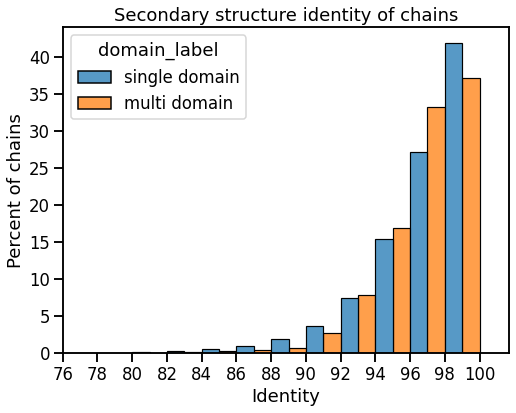

In [35]:
df = analyses_by_level['chain2chain']
df = df[df.analysis_name == 'CompareSecondaryStructure']
df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain
# todo mozna dat na single domain vsechny, kde nebyly nalezeny domeny?
#  - ne to je spis spatne, to muzou byt i velke proteiny..

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'

LOWER_DISPLAY_BOUND_ON_SS_IDENTITY = 0.76

outliers = df[df.result < LOWER_DISPLAY_BOUND_ON_SS_IDENTITY]
print(outliers)
print('outliers:', len(outliers))
print('all:', len(df))

def rounded_bins(a, binwidth):
    lower_bound = math.floor(np.min(a) / binwidth) * binwidth
    upper_bound = math.ceil(np.max(a) / binwidth) * binwidth

    return np.linspace(lower_bound, upper_bound, 1 + (int) ((upper_bound-lower_bound) / binwidth))

df['result_percent'] = df.result * 100
LOWER_DISPLAY_BOUND_ON_SS_IDENTITY *=100
BINWIDTH = 2
hue_order = ['single domain', 'multi domain']
ax = sns.histplot(df, x='result_percent', stat='percent', common_norm=False, hue='domain_label',
             hue_order=hue_order, multiple='dodge', bins=rounded_bins(df['result_percent'], BINWIDTH))
             # hue_order=hue_order, multiple='dodge', binwidth=BINWIDTH, binrange=(LOWER_DISPLAY_BOUND_ON_SS_IDENTITY, 1))  # gate out outliers (148)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set(xlim=(LOWER_DISPLAY_BOUND_ON_SS_IDENTITY, None))
ax.set_title('Secondary structure identity of chains')
ax.set_xlabel('Identity')
ax.set_ylabel('Percent of chains')
save_plot()

/var/folders/yd/d0qwckdj493c0xxb37j79t380000gn/T/ipykernel_20504/914023157.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_df['apo_holo_chain'] = domain_df.args.apply(lambda domain_pair: (domain_pair[0][0:2], domain_pair[1][0:2]))


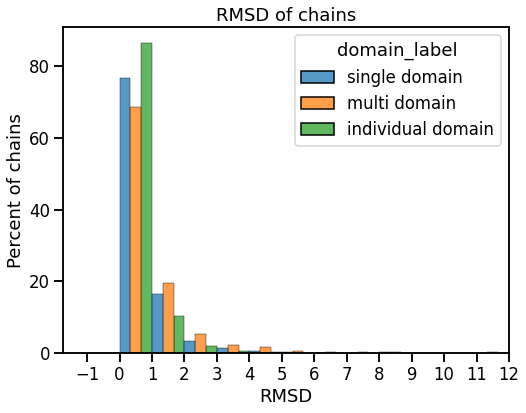

In [36]:
df = analyses_by_level['chain2chain']
df = df[df.analysis_name == 'GetRMSD']

df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'


d2d_rmsd = analyses_by_level['domain2domain'].query('analysis_name == "GetRMSD"')
# for merging, extract in new column only a-h tuple of (pdb_code, chain_id) from the a-h tuple of triples with also a
# domain_id
domain_df = d2d_rmsd[:]
domain_df['apo_holo_chain'] = domain_df.args.apply(lambda domain_pair: (domain_pair[0][0:2], domain_pair[1][0:2]))
domain_df = domain_df.merge(df[df.domain_label == 'multi domain']['args'], left_on='apo_holo_chain', right_on='args')
domain_df['domain_label'] = 'individual domain'

df = pd.concat([df, domain_df], ignore_index=True)

BINWIDTH = 1
ax = sns.histplot(df, x='result', stat='percent', common_norm=False, hue='domain_label', multiple='dodge',
                  bins=rounded_bins(df['result'], BINWIDTH), hue_order=hue_order + ['individual domain'])
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set(xlim=(None, 12))
ax.set_title('RMSD of chains')
ax.set_xlabel('RMSD')
ax.set_ylabel('Percent of chains')
save_plot()

## Domain motions
Two-domain arrangements

filter two-domain arrangements (if of both apo and holo > 200 A^2)

classified movements, 3 classes:
- shear (RMSD > 1 and < 2 Å)
- hinge (RMSD > 2 Å, bending > 10)
- other movement.

>We found that shear-type mechanism is
 the most frequent type of domain motion in the dataset
 (53%); hinge-bending is common for 45%, and the
 remaining cases cannot be unambiguously classified.

2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

In [37]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_by_level['chain2DA2chain2DA']
two_domain_arrangements = df[df.analysis_name == 'GetRMSD']['args']
two_domain_arrangements = unfold_tuple_to_columns(two_domain_arrangements, ['apo_domains', 'holo_domains'])
print('two-domain arrangements count (present in apo and holo)', len(two_domain_arrangements))
# podivej se na ty domeny, (full spany) a lcs a spočítej přes min a max délku v lcs a celkovou
# pro obe domény? Ano, pro kazdy par 2DA. Merguj s make_lcs

# add pair_id column, needed later
def make_pair_id_column(apo_domains, holo_domains):
    apo2DA_unfolded = unfold_tuple_to_columns(apo_domains, ['d1', 'd2'])
    holo2DA_unfolded = unfold_tuple_to_columns(holo_domains, ['d1', 'd2'])

    apo2DA_unfolded = unfold_tuple_to_columns(apo2DA_unfolded['d1'], ['pdb_code', 'chain_id', 'domain_id'])
    holo2DA_unfolded = unfold_tuple_to_columns(holo2DA_unfolded['d1'], ['pdb_code', 'chain_id', 'domain_id'])

    pair_id = tuple_columns(
        tuple_columns(apo2DA_unfolded['pdb_code'], apo2DA_unfolded['chain_id']),
        tuple_columns(holo2DA_unfolded['pdb_code'], holo2DA_unfolded['chain_id']),
    )
    return pair_id

two_domain_arrangements['pair_id'] = make_pair_id_column(two_domain_arrangements['apo_domains'], two_domain_arrangements['holo_domains'])

# muzu zjisit pouze z full vs analyzed... Jinak bych si musel ukladat jeste label_seq_id start ve filter_structures
# nikoliv z full vs lcs
def compute_observed_ratio(analyzed_domain_spans, full_domain_spans):
    def get_length(spans):
        length = 0
        for start, end in spans:
            length += end - start + 1
        return length
    return get_length(analyzed_domain_spans) / get_length(full_domain_spans)


# celkem tam jsou 4 domény (2 v apu, 2 v holu). A chci, aby to platilo pro všechny 4.
# asi bych to nemergoval a dělal rovnou loc..

# create dataframe of cols which will be added to two_domain_arrangements
ratios = defaultdict(list)
for row in two_domain_arrangements.itertuples():
    ad1, ad2 = row.apo_domains
    hd1, hd2 = row.holo_domains

    # todo no idea why the following does not work? Raises KeyError: "None of [Index(['1tgb', 'A', '1tgbA01'], dtype='object', name='full_id')] are in the [index]"
    # full_spans = full_domains.loc[ad1, 'spans']
    full_spans_d1 = full_domains.at[ad1, 'spans']
    full_spans_d2 = full_domains.at[ad2, 'spans']

    for colname, full_spans, d in zip(('ad1', 'ad2', 'hd1', 'hd2'), (full_spans_d1, full_spans_d2, full_spans_d1, full_spans_d2), (ad1, ad2, hd1, hd2)):
        analyzed_spans = analyzed_domains.at[(d, row.pair_id), 'spans']
        ratios[colname].append(compute_observed_ratio(analyzed_spans, full_spans))

two_domain_arrangements = two_domain_arrangements.assign(**ratios)

two-domain arrangements count (present in apo and holo) 258640


Remove too short lcs (join with a_h_pairs, where only >=50 aa lcs are). Either way, those were probably already removed in the short domain removal.

Select 2DAs only from ah_pairs (representatives for each UNP accession). Remove 2DAs that don't have meet the threshold for a observed residues in a domain:

In [38]:
df = two_domain_arrangements
# df = df[(df.ad1 > 0.5) & (df.ad2 > 0.5)]
OBSERVED_THRESHOLD = 0.5

# remove_data_with_short_domains
two_domain_arrangements = df[
    (df.ad1 > OBSERVED_THRESHOLD)
     & (df.ad2 > OBSERVED_THRESHOLD)
     & (df.hd1 > OBSERVED_THRESHOLD)
     & (df.hd2 > OBSERVED_THRESHOLD)
]
# and remove data with short lcs (already removed in a_h_pairs)
two_domain_arrangements = two_domain_arrangements[two_domain_arrangements.pair_id.isin(set(a_h_pairs['args']))]

print('valid two-domain arrangements count (present in apo and holo)', len(two_domain_arrangements))

allowed_2DA_ids = set(two_domain_arrangements.args)

filtered_results = []
for row in analyses_by_level['chain2DA2chain2DA'].itertuples(index=False):
    # I unfortunately wasn't strict in that each level tag has same args..
    if row.analysis_name == 'GetRMSD':
        _2DA_id = row.args
    else:
        _2DA_id = row.args[:2], row.args[2:]

    if _2DA_id in allowed_2DA_ids:
        filtered_results.append(row._asdict())

old_chain2DA2chain2DA = analyses_by_level['chain2DA2chain2DA']
analyses_by_level['chain2DA2chain2DA'] = pd.DataFrame.from_records(filtered_results)


# print(len(two_domain_arrangements2))
# df[~((df.ad1 > OBSERVED_THRESHOLD)
#      & (df.ad2 > OBSERVED_THRESHOLD)
#      & (df.hd1 > OBSERVED_THRESHOLD)
#      & (df.hd2 > OBSERVED_THRESHOLD))]

valid two-domain arrangements count (present in apo and holo) 2837


2837
2837
2837


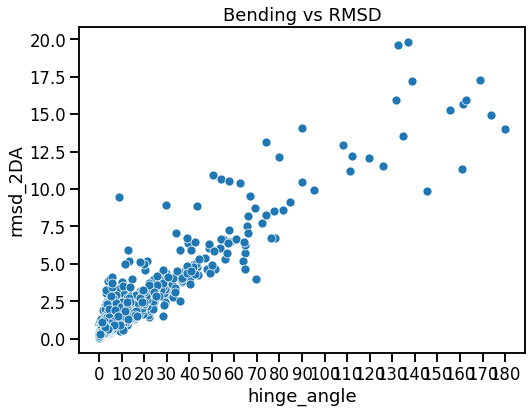

In [39]:
df = analyses_by_level['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']


# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

hinge_df = unfold_tuple_to_columns(hinge_df, ['apo_domains', 'holo_domains'], 'args')
hinge_df['pair_id'] = make_pair_id_column(hinge_df['apo_domains'], hinge_df['holo_domains'])

print(len(hinge_df))
print(len(rmsd_df))
rmsd_and_hinge = rmsd_df.merge(hinge_df, on='args')

print(len(rmsd_and_hinge))
ax = sns.scatterplot(data=rmsd_and_hinge, x='hinge_angle', y='rmsd_2DA')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))
ax.set_title('Bending vs RMSD')
save_plot()
# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají ~~translation_in_axis~~ translation_overall, třeba
# větší než hinge'
# podle mě částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Nemusi, kdyz jedna domena je treba mensi..



14:56 jsem odstranil ty páry, co neměly žádný dobrý domény, ale nikoliv podle přímo těch domén, to až teď

## Shear, as classified in the paper
- classified as RMSD value between 1 and 2 (RMSD of apo and holo two-domain arrangements)
- or rather it incorrectly includes cases, where only one domain accommodates the ligand

In [40]:
print(len(rmsd_and_hinge))
print(len(d2d_rmsd))

2837
965769


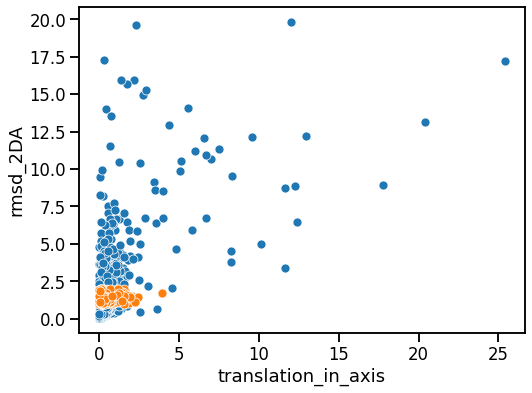

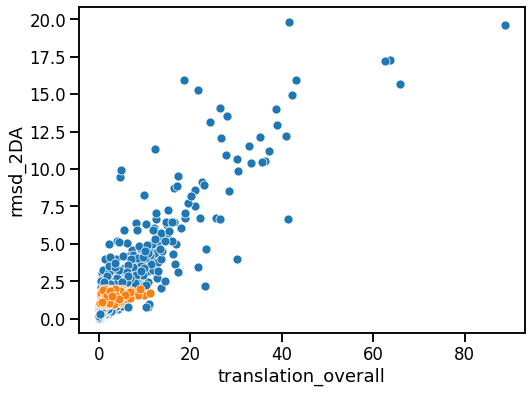

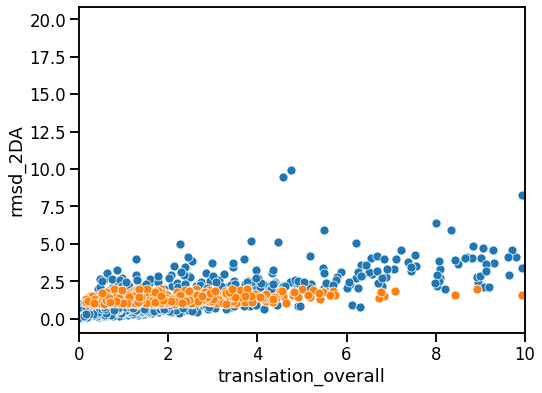

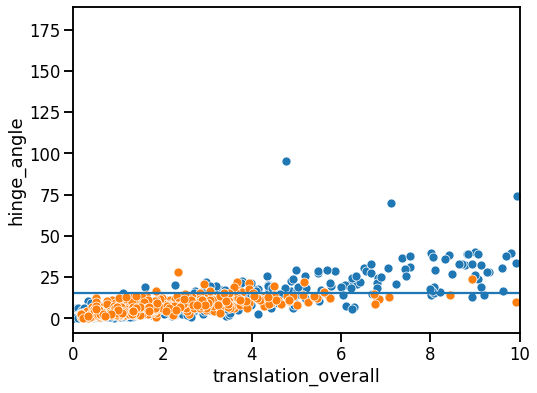

,hinge_angle,translation_overall,translation_in_axis,rmsd_2DA,domain_rmsd_x,domain_rmsd_y
1296,2.142471,0.165414,0.076953,1.293088,0.940240,1.745594
1538,2.592840,0.166126,0.150640,1.330382,1.676614,0.401054
1089,0.742304,0.171255,0.043376,1.047496,1.149980,0.307888
1870,2.481439,0.172734,0.060382,1.149853,1.377057,0.879665
2110,0.429783,0.206997,0.041641,1.187808,0.055015,1.307815
...,...,...,...,...,...,...
521,12.593303,7.076728,0.553635,1.848996,0.792324,0.297603
1472,14.049562,8.438701,0.869483,1.575134,0.850217,1.118423
1585,23.840707,8.923039,0.074220,1.993601,0.573358,1.324105
465,9.549255,9.926409,1.700883,1.614193,0.353644,0.615736


In [41]:
df = rmsd_and_hinge[:]
df = unfold_tuple_to_columns(df, ['apo_domains', 'holo_domains'], 'args')
df = unfold_tuple_to_columns(df, ['apo_domain_1', 'apo_domain_2'], 'apo_domains')
df = unfold_tuple_to_columns(df, ['holo_domain_1', 'holo_domain_2'], 'holo_domains')
# convert args, so that format is the same - as single domain rmsd
df['d1_id'] = tuple_columns(df.apo_domain_1, df.holo_domain_1)
df['d2_id'] = tuple_columns(df.apo_domain_2, df.holo_domain_2)
d2d_rmsd_selected_cols = d2d_rmsd[['args', 'result']].rename(columns={'args': 'rmsd_domain_id', 'result': 'domain_rmsd'})
df = df.merge(d2d_rmsd_selected_cols, left_on='d1_id', right_on='rmsd_domain_id')
df = df.merge(d2d_rmsd_selected_cols, left_on='d2_id', right_on='rmsd_domain_id')

all = df[:]
paper_shear = df[(1 < df.rmsd_2DA) & (df.rmsd_2DA < 2)]  # gather shears

# rmsd_2DA vs translation_in_axis
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_in_axis', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_in_axis', y='rmsd_2DA')
plt.show()


# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='rmsd_2DA')
plt.show()

# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='rmsd_2DA')
ax.set(xlim=(0, 10))
plt.show()


ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='hinge_angle')
ax.set(xlim=(0, 10))
ax.axhline(15)
plt.show()

paper_shear[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')

# all = all[all.rmsd_2DA > 1]
# all[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')


In [42]:
paper_shear.sort_values(by='translation_overall')

,Index_x,analysis_name_x,args,kwargs_x,rmsd_2DA,level_tag_x,Index_y,analysis_name_y,kwargs_y,result,...,apo_domain_1,apo_domain_2,holo_domain_1,holo_domain_2,d1_id,d2_id,rmsd_domain_id_x,domain_rmsd_x,rmsd_domain_id_y,domain_rmsd_y
1296,1869,GetRMSD,"(((1ulh, A, 1ulhA01), (1ulh, A, 1ulhA02)), ((2...",{},1.293088,chain2DA2chain2DA,1868,GetHingeAngle,{},"{'angle': 0.037393174048062, 'translation_in_a...",...,"(1ulh, A, 1ulhA01)","(1ulh, A, 1ulhA02)","(2quj, B, 1ulhA01)","(2quj, B, 1ulhA02)","((1ulh, A, 1ulhA01), (2quj, B, 1ulhA01))","((1ulh, A, 1ulhA02), (2quj, B, 1ulhA02))","((1ulh, A, 1ulhA01), (2quj, B, 1ulhA01))",0.940240,"((1ulh, A, 1ulhA02), (2quj, B, 1ulhA02))",1.745594
1538,197,GetRMSD,"(((3la7, B, 3la7B01), (3la7, B, 3la7B02)), ((3...",{},1.330382,chain2DA2chain2DA,196,GetHingeAngle,{},"{'angle': 0.045253598980063, 'translation_in_a...",...,"(3la7, B, 3la7B01)","(3la7, B, 3la7B02)","(3la7, A, 3la7B01)","(3la7, A, 3la7B02)","((3la7, B, 3la7B01), (3la7, A, 3la7B01))","((3la7, B, 3la7B02), (3la7, A, 3la7B02))","((3la7, B, 3la7B01), (3la7, A, 3la7B01))",1.676614,"((3la7, B, 3la7B02), (3la7, A, 3la7B02))",0.401054
1089,743,GetRMSD,"(((3fxy, A, 3fxyA01), (3fxy, A, 3fxyA02)), ((3...",{},1.047496,chain2DA2chain2DA,742,GetHingeAngle,{},"{'angle': 0.012955656195231001, 'translation_i...",...,"(3fxy, A, 3fxyA01)","(3fxy, A, 3fxyA02)","(3rm8, A, 3fxyA01)","(3rm8, A, 3fxyA02)","((3fxy, A, 3fxyA01), (3rm8, A, 3fxyA01))","((3fxy, A, 3fxyA02), (3rm8, A, 3fxyA02))","((3fxy, A, 3fxyA01), (3rm8, A, 3fxyA01))",1.149980,"((3fxy, A, 3fxyA02), (3rm8, A, 3fxyA02))",0.307888
1870,1743,GetRMSD,"(((2i87, A, 2i87A01), (2i87, A, 2i87A02)), ((2...",{},1.149853,chain2DA2chain2DA,1742,GetHingeAngle,{},"{'angle': 0.043309279726835, 'translation_in_a...",...,"(2i87, A, 2i87A01)","(2i87, A, 2i87A02)","(2i8c, B, 2i87A01)","(2i8c, B, 2i87A02)","((2i87, A, 2i87A01), (2i8c, B, 2i87A01))","((2i87, A, 2i87A02), (2i8c, B, 2i87A02))","((2i87, A, 2i87A01), (2i8c, B, 2i87A01))",1.377057,"((2i87, A, 2i87A02), (2i8c, B, 2i87A02))",0.879665
2110,2115,GetRMSD,"(((1v7v, A, 1v7vA02), (1v7v, A, 1v7vA03)), ((1...",{},1.187808,chain2DA2chain2DA,2114,GetHingeAngle,{},"{'angle': 0.007501136480507001, 'translation_i...",...,"(1v7v, A, 1v7vA02)","(1v7v, A, 1v7vA03)","(1v7w, A, 1v7vA02)","(1v7w, A, 1v7vA03)","((1v7v, A, 1v7vA02), (1v7w, A, 1v7vA02))","((1v7v, A, 1v7vA03), (1v7w, A, 1v7vA03))","((1v7v, A, 1v7vA02), (1v7w, A, 1v7vA02))",0.055015,"((1v7v, A, 1v7vA03), (1v7w, A, 1v7vA03))",1.307815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,991,GetRMSD,"(((3zzm, B, 3zzmB01), (3zzm, B, 3zzmB02)), ((4...",{},1.848996,chain2DA2chain2DA,990,GetHingeAngle,{},"{'angle': 0.21979459560727102, 'translation_in...",...,"(3zzm, B, 3zzmB01)","(3zzm, B, 3zzmB02)","(4a1o, A, 3zzmB01)","(4a1o, A, 3zzmB02)","((3zzm, B, 3zzmB01), (4a1o, A, 3zzmB01))","((3zzm, B, 3zzmB02), (4a1o, A, 3zzmB02))","((3zzm, B, 3zzmB01), (4a1o, A, 3zzmB01))",0.792324,"((3zzm, B, 3zzmB02), (4a1o, A, 3zzmB02))",0.297603
1472,1995,GetRMSD,"(((3c0n, B, 3c0nB01), (3c0n, B, 3c0nB03)), ((3...",{},1.575134,chain2DA2chain2DA,1994,GetHingeAngle,{},"{'angle': 0.24521110823587802, 'translation_in...",...,"(3c0n, B, 3c0nB01)","(3c0n, B, 3c0nB03)","(3c0o, A, 3c0nB01)","(3c0o, A, 3c0nB03)","((3c0n, B, 3c0nB01), (3c0o, A, 3c0nB01))","((3c0n, B, 3c0nB03), (3c0o, A, 3c0nB03))","((3c0n, B, 3c0nB01), (3c0o, A, 3c0nB01))",0.850217,"((3c0n, B, 3c0nB03), (3c0o, A, 3c0nB03))",1.118423
1585,1477,GetRMSD,"(((1ng2, A, 1ng2A01), (1ng2, A, 1ng2A02)), ((1...",{},1.993601,chain2DA2chain2DA,1476,GetHingeAngle,{},"{'angle': 0.41609882646502905, 'translation_in...",...,"(1ng2, A, 1ng2A01)","(1ng2, A, 1ng2A02)","(1ov3, A, 1ng2A01)","(1ov3, A, 1ng2A02)","((1ng2, A, 1ng2A01), (1ov3, A, 1ng2A01))","((1ng2, A, 1ng2A02), (1ov3, A, 1ng2A02))","((1ng2, A, 1ng2A01), (1ov3, A, 1ng2A01))",0.573358,"((1ng2, A, 1ng2A02), (1ov3, A, 1ng2A02))",1.324105
465,2375,GetRMSD,"(((5knl, A, 5knlA03), (5knl, A, 5knlA06)), ((4...",{}

In [43]:
# jak to, ze maji rmsd 1-2 a pritom tak velky hinge?
# Mozna se podivat na analyzed domain definition
# ano - treba 3kqg, 3p5d, holo struktura je kratsi a ma jenom jednu domenu, ale premapovani ty druhy apo
# zpusobi, ze bude mit treba jenom 2 residua, ktery se zrovna moc nehybou...
# Rekl bych, ze tyhle pripady (krome thresholdu na pomer zbyly residui v domene) by se odfiltrovaly
# i tim 200 A^2 thresholdem na interface
paper_shear[paper_shear.hinge_angle > 75]


,Index_x,analysis_name_x,args,kwargs_x,rmsd_2DA,level_tag_x,Index_y,analysis_name_y,kwargs_y,result,...,apo_domain_1,apo_domain_2,holo_domain_1,holo_domain_2,d1_id,d2_id,rmsd_domain_id_x,domain_rmsd_x,rmsd_domain_id_y,domain_rmsd_y


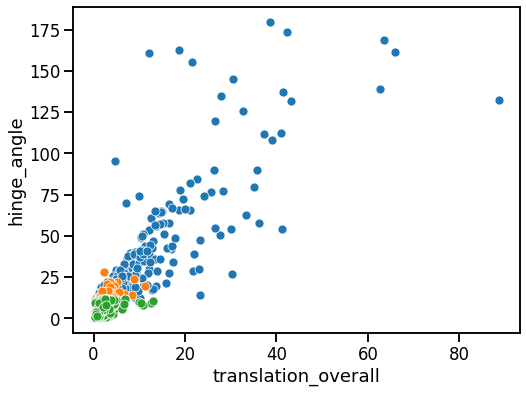

In [44]:
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=rmsd_and_hinge[
    (rmsd_and_hinge.translation_overall > 0.2) & (rmsd_and_hinge.hinge_angle < 12)], x='translation_overall', y='hinge_angle')


/Users/adam/venvs/apo-holo-protein-structure-stats/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'args_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


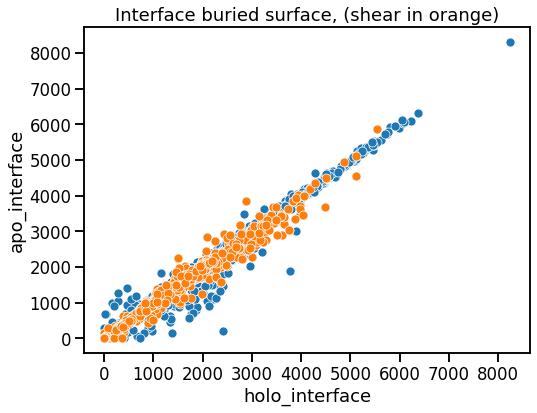

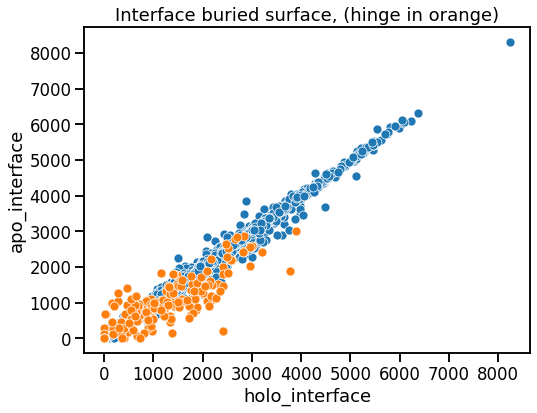

In [45]:
df = analyses_by_level['2DA']

interface_area = df[df.analysis_name == 'GetInterfaceBuriedArea']
df = unfold_tuple_to_columns(interface_area, ['d1', 'd2', 'pair_id'], 'args')
interface_area['2DA_id'] = tuple_columns(df.d1, df.d2)
interface_area['pair_id'] = df['pair_id']
interface_area = interface_area.set_index(['2DA_id', 'pair_id'])

df = two_domain_arrangements.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_index=True)
df = df.rename(columns={'result': 'apo_interface'})
df = df.merge(interface_area, left_on=['holo_domains', 'pair_id'], right_index=True)
df = df.rename(columns={'result': 'holo_interface'})

interface_area_apo_holo = df

def show_all():
    ax = sns.scatterplot(data=df, x='holo_interface', y='apo_interface')
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))

df = df.merge(hinge_df, left_on=['apo_domains', 'pair_id'], right_on=['apo_domains', 'pair_id'])

def show_shear():
    sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 15)], x='holo_interface', y='apo_interface')

def show_hinge():
    sns.scatterplot(data=df[(df.hinge_angle > 15)], x='holo_interface', y='apo_interface')

show_all()
show_shear()
plt.title('Interface buried surface, (shear in orange)')
save_plot()
plt.show()


show_all()
show_hinge()
plt.title('Interface buried surface, (hinge in orange)')
save_plot()
plt.show()
# todo udělat diagonálu

# df[df.apo_interface > 6000]
# 8300 outlier = large beta barrel 1pnz, 1kmo


Compared to the paper, it's estimated as larger.

2DA
prediktor large-scale motion type z apo interface buried

interface buried (apo) vs (bending)|(RMSD - opět 2DA-explicitně)
- scatter and histogram


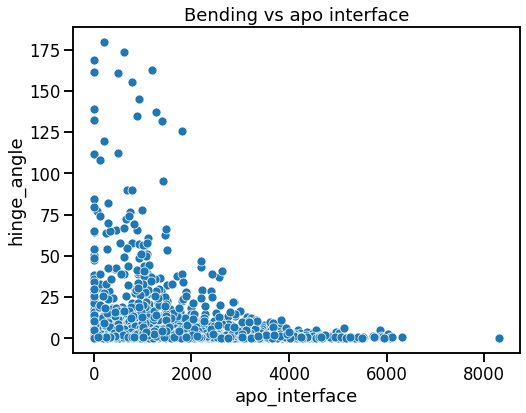

In [46]:
df = hinge_df
df = df.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result_y': 'apo_interface'})

# to nefunguje, kdyz to neni v tom contextu, tak to nic nedělá
# sns.set_context("notebook", rc={"scatter.marker": ','})
#
# import matplotlib as mpl
# # mpl.rcdefaults()
# mpl.rc('scatter', marker='o')
# mpl.rc('lines', markersize=2)
# mpl.rc('figure', figsize=[12, 8])

# sns.set_theme()
ax = sns.scatterplot(data=df, x='apo_interface', y='hinge_angle')
ax.set_title('Bending vs apo interface')
save_plot()
# true shear dataset
# sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 12)], x='apo_interface', y='hinge_angle')
# mpl.rcdefaults()
# sns.set_context()

plt.rcParams['figure.figsize'] = [12, 8]We can see that domain interface area (in apo structure) indeed sets a limit on whether the domains can do a hinge motion. Hinge bending domain pairs with interface area larger than 2000 Å^2 were not observed.

The conclusion for shear, in the paper, holds too.
No lg scale dom. movements above 3550 A2 interface.

deducible by the
examination of a ligand-free structural form alone.
- mění se něco? Může to být víc deducible ještě z něčeho novýho, co máme ted k dispozici? Asi ne..

Zkusil bych ještě |holo_interface-apo_interface|/apo_interface vs hinge angle
Ale to, že to nedělá 90° protože by zmizel interface je moc noisy závěr. Možná pro 'nejtěžší' principal axis by to šlo říct.

,Index_x,analysis_name_x,args_x,kwargs_x,result_x,level_tag_x,hinge_angle,translation_in_axis,translation_overall,apo_domains,...,kwargs_y,apo_interface,level_tag_y,Index,analysis_name,args,kwargs,holo_interface,level_tag,interface_change_ratio
350,994,GetHingeAngle,"(((1k04, A, 1k04A01), (1k04, A, 1k04A02)), ((1...",{},"{'angle': 3.139521051321354, 'translation_in_a...",chain2DA2chain2DA,179.881306,0.463536,38.625763,"((1k04, A, 1k04A01), (1k04, A, 1k04A02))",...,{},203.978522,2DA,989,GetInterfaceBuriedArea,"((1ow6, C, 1k04A01), (1ow6, C, 1k04A02), ((1k0...",{},2404.085989,2DA,10.785976
359,210,GetHingeAngle,"(((3fwe, B, 3fweB01), (3fwe, B, 3fweB02)), ((3...",{},"{'angle': 2.808321026484222, 'translation_in_a...",chain2DA2chain2DA,160.904942,7.516496,12.198724,"((3fwe, B, 3fweB01), (3fwe, B, 3fweB02))",...,{},508.098335,2DA,205,GetInterfaceBuriedArea,"((3kcc, B, 3fweB01), (3kcc, B, 3fweB02), ((3fw...",{},865.304251,2DA,0.703025
1321,1058,GetHingeAngle,"(((1y1a, A, 1y1aA01), (1y1a, A, 1y1aA02)), ((6...",{},"{'angle': 3.034966168070847, 'translation_in_a...",chain2DA2chain2DA,173.890752,2.723159,42.306129,"((1y1a, A, 1y1aA01), (1y1a, A, 1y1aA02))",...,{},615.700861,2DA,1053,GetInterfaceBuriedArea,"((6ocx, C, 1y1aA01), (6ocx, C, 1y1aA02), ((1y1...",{},1269.052582,2DA,1.061151
2555,5446,GetHingeAngle,"(((1ygy, A, 1ygyA01), (1ygy, A, 1ygyA03)), ((3...",{},"{'angle': 2.71627002531367, 'translation_in_ax...",chain2DA2chain2DA,155.630808,2.948981,21.598845,"((1ygy, A, 1ygyA01), (1ygy, A, 1ygyA03))",...,{},793.731551,2DA,5431,GetInterfaceBuriedArea,"((3ddn, B, 1ygyA01), (3ddn, B, 1ygyA03), ((1yg...",{},548.906674,2DA,-0.308448
2557,5450,GetHingeAngle,"(((1ygy, A, 1ygyA02), (1ygy, A, 1ygyA03)), ((3...",{},"{'angle': 2.841974669807678, 'translation_in_a...",chain2DA2chain2DA,162.833154,1.353367,18.587845,"((1ygy, A, 1ygyA02), (1ygy, A, 1ygyA03))",...,{},1192.940092,2DA,5433,GetInterfaceBuriedArea,"((3ddn, B, 1ygyA02), (3ddn, B, 1ygyA03), ((1yg...",{},642.174076,2DA,-0.461688


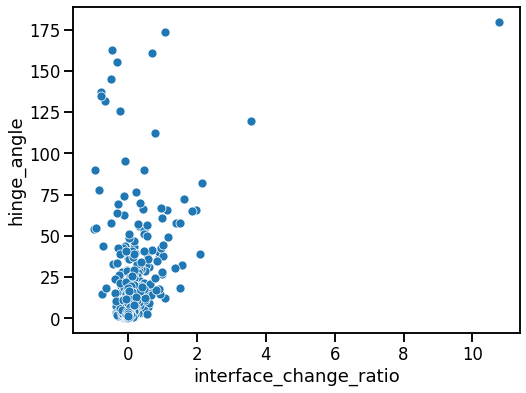

In [47]:
df = hinge_df
df = df.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result_y': 'apo_interface'})
df = df.merge(interface_area, left_on=['holo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result': 'holo_interface'})

df['interface_change_ratio'] = (df['holo_interface'] - df['apo_interface']) / df['apo_interface']
df = df[df['apo_interface'] >= 200]
sns.scatterplot(data=df, x='interface_change_ratio', y='hinge_angle')
df[df.hinge_angle > 150]


2837
2837


<AxesSubplot:xlabel='apo_interface', ylabel='rmsd_2DA'>

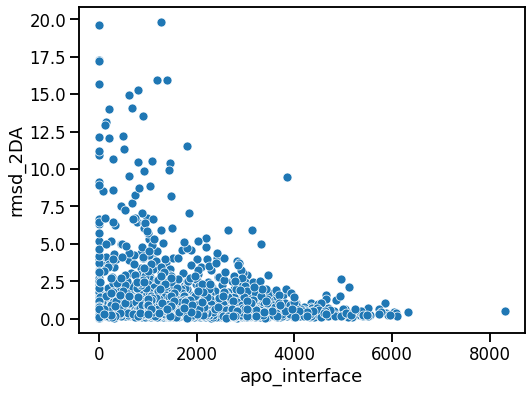

In [48]:
df = rmsd_df
df = unfold_tuple_to_columns(df, ['apo_domains', 'holo_domains'], 'args')
df['pair_id'] = make_pair_id_column(df['apo_domains'], df['holo_domains'])

print(len(df))
df = df.merge(interface_area.rename(columns={'result': 'apo_interface'}), left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
print(len(df))
sns.scatterplot(data=df, x='apo_interface', y='rmsd_2DA')

